In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os


#jupyter nbconvert --to script ImageComparisonGenerator.ipynb

class ImageComparisonGenerator:

    def __init__(self, model, model_name1="Prediction", model2=None, model_name2="Prediction"):
        self.model  = model
        self.model_name1 = model_name1
        self.model2 = model2
        self.model_name2 = model_name2

    def get_model_output(self,images, model=None):
        if model is None:
            return self.model(images)
        else:
            return model(images)
    
    # Função auxiliar dentro da classe
    def _get_sample_by_index(self, dataloader, idx):
        count = 0
        for imgs, masks in dataloader:
            batch_size = imgs.shape[0]
            if idx < count + batch_size:
                local_idx = idx - count
                return imgs[local_idx:local_idx+1], masks[local_idx]
            count += batch_size
        raise IndexError(f"Index {idx} out of range for dataset of length {len(dataloader.dataset)}")


    # Funções auxiliares
    def _prepare_mask_vis(self, mask, num_classes=1, ignore_val=255):
        ignore_mask = (mask == ignore_val)
        mask_vis = mask.copy()
        
        if num_classes > 1:
            color_map = {0:[0.9,0.9,0],1:[0.3,0.3,1],2:[0.9,0,0.9]}
            mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)
            for class_val, color in color_map.items():
                mask_rgb[mask == class_val] = color
            mask_rgb[ignore_mask] = [0.8,0.8,0.8]
            mask_vis = mask_rgb
        else:
            mask_vis[ignore_mask] = -1
        return mask_vis, ignore_mask

    def _prepare_prediction_vis(self, output, mask, num_classes=1, do_diff=True, invert_diff_colors=False, ignore_mask=None):
        if num_classes == 1:
            out_sigmoid = torch.sigmoid(output[0])
            pred = (out_sigmoid > 0.5).float().cpu().squeeze().numpy()
        else:
            out_softmax = torch.softmax(output[0], dim=0)
            pred = torch.argmax(out_softmax, dim=0).cpu().numpy()

        if do_diff:
            if len(mask.shape) == 2:
                h, w = mask.shape
            else:
                h, w, _ = mask.shape

            diff_img = np.zeros((h, w, 3), dtype=np.float32)
            if num_classes == 1:
                tp = (pred == 1) & (mask == 1)
                fn = (pred == 0) & (mask == 1)
                fp = (pred == 1) & (mask == 0)
                if invert_diff_colors:
                    diff_img[tp] = [1,1,1]
                    diff_img[fp] = [1,0.5,0]
                    diff_img[fn] = [1,0,0]
                else:
                    diff_img[tp] = [1,1,1]
                    diff_img[fn] = [1,0.5,0]
                    diff_img[fp] = [1,0,0]
            else:
                color_map = {0:[0.9,0.9,0],1:[0.3,0.3,1],2:[0.9,0,0.9]}
                mismatches = (mask != pred)
                mismatches[ignore_mask] = False
                for cls in range(num_classes):
                    cls_mask = (mask == cls) & (pred == cls)
                    diff_img[cls_mask] = color_map.get(cls,[1,1,1])
                diff_img[mismatches] = [1,0,0]
                diff_img[ignore_mask] = [0.8,0.8,0.8]
            return diff_img
        else:
            if num_classes > 1:
                color_map = {0:[0.9,0.9,0],1:[0.3,0.3,1],2:[0.9,0,0.9]}
                pred_vis = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)
                for class_val, color in color_map.items():
                    pred_vis[pred == class_val] = color
                return pred_vis
            else:
                return pred

    def _prepare_image_disp(self, img):
        img_disp = img.cpu().squeeze()
        if img_disp.ndim == 3 and img_disp.shape[0] == 3:
            img_disp = img_disp.permute(1,2,0)
        elif img_disp.ndim == 3 and img_disp.shape[0] == 1:
            img_disp = img_disp.squeeze(0)
        img_disp = img_disp*0.5 + 0.5
        return img_disp
    


    def compare_models_on_val(self, val_loader, modelB, num_classes=1, device="cuda", max_images=None):
        modelA = self.model
        modelB.eval()
        modelA.to(device)
        modelB.to(device)
        img_count = 0
        
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                # Forward nos dois modelos
                outA = modelA(imgs)
                outB = modelB(imgs)

                # Se forem logits, aplica softmax ou sigmoid
                if num_classes == 1:
                    predA = torch.sigmoid(outA) > 0.5
                    predB = torch.sigmoid(outB) > 0.5
                else:
                    predA = torch.argmax(F.softmax(outA, dim=1), dim=1)
                    predB = torch.argmax(F.softmax(outB, dim=1), dim=1)

                # Calcular Dice por imagem
                for i in range(imgs.size(0)):
                    diceA = self._dice_score(predA[i], masks[i], num_classes)
                    diceB = self._dice_score(predB[i], masks[i], num_classes)
                    mIoUA = self._miou_score(predA[i], masks[i], num_classes)
                    mIoUB = self._miou_score(predB[i], masks[i], num_classes)

                    if diceA > diceB:
                        # Preparar imagens para visualização
                        img_disp = self._prepare_image_disp(imgs[i].cpu())

                                                
                        mask_np = masks[i].cpu().squeeze().numpy()
                        gt_disp, ignore_mask = self._prepare_mask_vis(mask_np, num_classes)

                        predA_disp = self._prepare_prediction_vis(outA,
                                                                mask_np,
                                                                num_classes=num_classes,
                                                                do_diff=True,
                                                                ignore_mask=ignore_mask)

                        predB_disp = self._prepare_prediction_vis(outB,
                                                                mask_np,
                                                                num_classes=num_classes,
                                                                do_diff=True,
                                                                ignore_mask=ignore_mask)

                        red_pixels = np.all(predA_disp == np.array([1.0, 0.0, 0.0], dtype=np.float32), axis=2)
                        num_red_pixelsA = np.sum(red_pixels)
                        red_pixels = np.all(predB_disp == np.array([1.0, 0.0, 0.0], dtype=np.float32), axis=2)
                        num_red_pixelsB = np.sum(red_pixels)

                        # Mostrar em uma figura 2x2
                        fig, axs = plt.subplots(2, 2, figsize=(8, 8))
                        axs[0,0].imshow(img_disp); axs[0,0].set_title("Imagem")
                        axs[0,1].imshow(gt_disp); axs[0,1].set_title("GT")
                        axs[1,0].imshow(predA_disp); axs[1,0].set_title(f"Modelo A Dice={diceA:.3f} mIoU={mIoUA:.3f} \n Red:{num_red_pixelsA}")
                        axs[1,1].imshow(predB_disp); axs[1,1].set_title(f"Modelo B Dice={diceB:.3f} mIoU={mIoUB:.3f} \n Red:{num_red_pixelsB}")

                        

                        for ax in axs.flat: ax.axis("off")
                        plt.tight_layout()
                        plt.show()

                        img_count += 1
                        if max_images is not None and img_count >= max_images:
                            return

    def _miou_score(self, pred, target, num_classes=1, ignore_val=255, eps=1e-6):
        pred = pred.view(-1)
        target = target.view(-1)
        
        # Máscara de ignorados
        valid_mask = (target != ignore_val)
        
        iou_total = 0.0
        for c in range(num_classes):
            pred_c = (pred == c) & valid_mask
            target_c = (target == c) & valid_mask
            
            inter = (pred_c & target_c).sum().item()
            union = (pred_c | target_c).sum().item()
            
            if union == 0:
                iou = 1.0  # se a classe não está presente nem na GT nem na predição
            else:
                iou = inter / (union + eps)
            
            iou_total += iou
        
        return iou_total / num_classes


    def _dice_score(self, pred, target, num_classes=1, eps=1e-6):
        """
        Calcula Dice Score entre predição e ground truth.
        """
        if num_classes == 1:
            pred = pred.view(-1).float()
            target = target.view(-1).float()
            inter = (pred * target).sum()
            return (2 * inter + eps) / (pred.sum() + target.sum() + eps)
        else:
            dice_total = 0
            for c in range(num_classes):
                pred_c = (pred == c).float().view(-1)
                target_c = (target == c).float().view(-1)
                inter = (pred_c * target_c).sum()
                dice_total += (2 * inter + eps) / (pred_c.sum() + target_c.sum() + eps)
            return dice_total / num_classes


    # Funções de saída
    def save_output_row(self, sample_loader, samples=[0],
                        num_classes=1, do_diff=True, invert_diff_colors=False,
                        do_save=False):
        if self.model is None:
            raise Exception("The model is not loaded.")

        device = next(self.model.parameters()).device
        self.model.eval()
        num_rows = len(samples)
        fig = plt.figure(figsize=(11, 4*num_rows))

        with torch.no_grad():
            for idx, sample_idx in enumerate(samples):
                img, mask = self._get_sample_by_index(sample_loader, sample_idx)
                img = img.to(device)
                mask = mask.cpu().squeeze().numpy()

                mask_vis, ignore_mask = self._prepare_mask_vis(mask, num_classes)
                pred_vis = self._prepare_prediction_vis(self.get_model_output(img), mask, num_classes, do_diff, invert_diff_colors, ignore_mask)
                img_disp = self._prepare_image_disp(img)

                for col, im in enumerate([img_disp, mask_vis, pred_vis]):
                    ax = fig.add_axes([
                        col/3, 1-(idx+1)/num_rows, 1/3, 1/num_rows
                    ])
                    ax.imshow(im, cmap='gray' if num_classes==1 else None, aspect='auto')
                    ax.set_xticks([]); ax.set_yticks([])
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1.5)
                    if idx==0:
                        font_size = 30
                        if col==0: ax.set_title("Image", fontsize=font_size, y=1.0)
                        elif col==1: ax.set_title("Ground Truth", fontsize=font_size, y=1.0)
                        else: ax.set_title("Prediction", fontsize=font_size, y=1.0)

        plt.tight_layout(rect=[0,0,1,0.96])
        if do_save: fig.savefig(do_save, format='eps', bbox_inches='tight', pad_inches=0.1)
        else: plt.show()


    def save_output_quad(self, sample_loader, samples=[0],
                        num_classes=1, do_diff=True, invert_diff_colors=False,
                        do_save=False):
        if self.model is None:
            raise Exception("The model is not loaded.")

        device1 = next(self.model.parameters()).device
        device2 = next(self.model2.parameters()).device if self.model2 is not None else device1

        self.model.eval()
        if self.model2 is not None:
            self.model2.eval()

        fig = plt.figure(figsize=(10,10))  # maior largura para 2 modelos

        with torch.no_grad():
            for idx, sample_idx in enumerate(samples):
                img, mask = self._get_sample_by_index(sample_loader, sample_idx)
                img = img.to(device1)
                mask_np = mask.cpu().squeeze().numpy()

                mask_vis, ignore_mask = self._prepare_mask_vis(mask_np, num_classes)

                # Predição do modelo 1
                pred1_vis = self._prepare_prediction_vis(
                    self.get_model_output(img, model=self.model), 
                    mask_np, num_classes, do_diff, invert_diff_colors, ignore_mask
                )
                img_disp = self._prepare_image_disp(img)

                # Predição do modelo 2, se existir
                if self.model2 is not None:
                    img2 = img.to(device2)
                    pred2_vis = self._prepare_prediction_vis(
                        self.get_model_output(img2, model=self.model2),
                        mask_np, num_classes, do_diff, invert_diff_colors, ignore_mask
                    )
                else:
                    pred2_vis = None

                vertical_gap = 0.13
                height = (1 - vertical_gap) / 2

                # Estrutura das posições: (linha, coluna, imagem, título)
                positions = [
                    (0,0,img_disp,"Image"),
                    (0,1,mask_vis,"Ground Truth"),
                    (1,0,pred1_vis,self.model_name1),
                    (1,1,pred2_vis,self.model_name2 if self.model2 is not None else "Prediction")
                ]

                for row, col, im, title in positions:
                    bottom = 1 - (row + 1)*(height + vertical_gap/2)
                    ax = fig.add_axes([col/2, bottom, 1/2, height])
                    if im is not None:
                        ax.imshow(im, cmap='gray' if num_classes==1 else None, aspect='auto')
                    ax.set_xticks([]); ax.set_yticks([])
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1.5)
                    font_size = 30
                    ax.set_title(title, fontsize=font_size, y=1.0)

        plt.tight_layout(rect=[0,0,1,0.96])
        if do_save:
            fig.savefig(do_save, format='eps', bbox_inches='tight', pad_inches=0.1)
        else:
            plt.show()







In [ ]:

class ImageComparisonGenMobileNetV2(ImageComparisonGenerator):
    def get_model_output(self,images):
        return self.model(images)['out']

def load_model(model, model_file_name):
    checkpoint = torch.load(model_file_name, map_location='cpu')
    state_dict = checkpoint['model_state_dict']

    # Filtra apenas as chaves existentes no modelo
    model_keys = set(model.state_dict().keys())
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_keys}

    model.load_state_dict(filtered_state_dict, strict=False)
    return model

/tmp/ipykernel_83170/4100354651.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


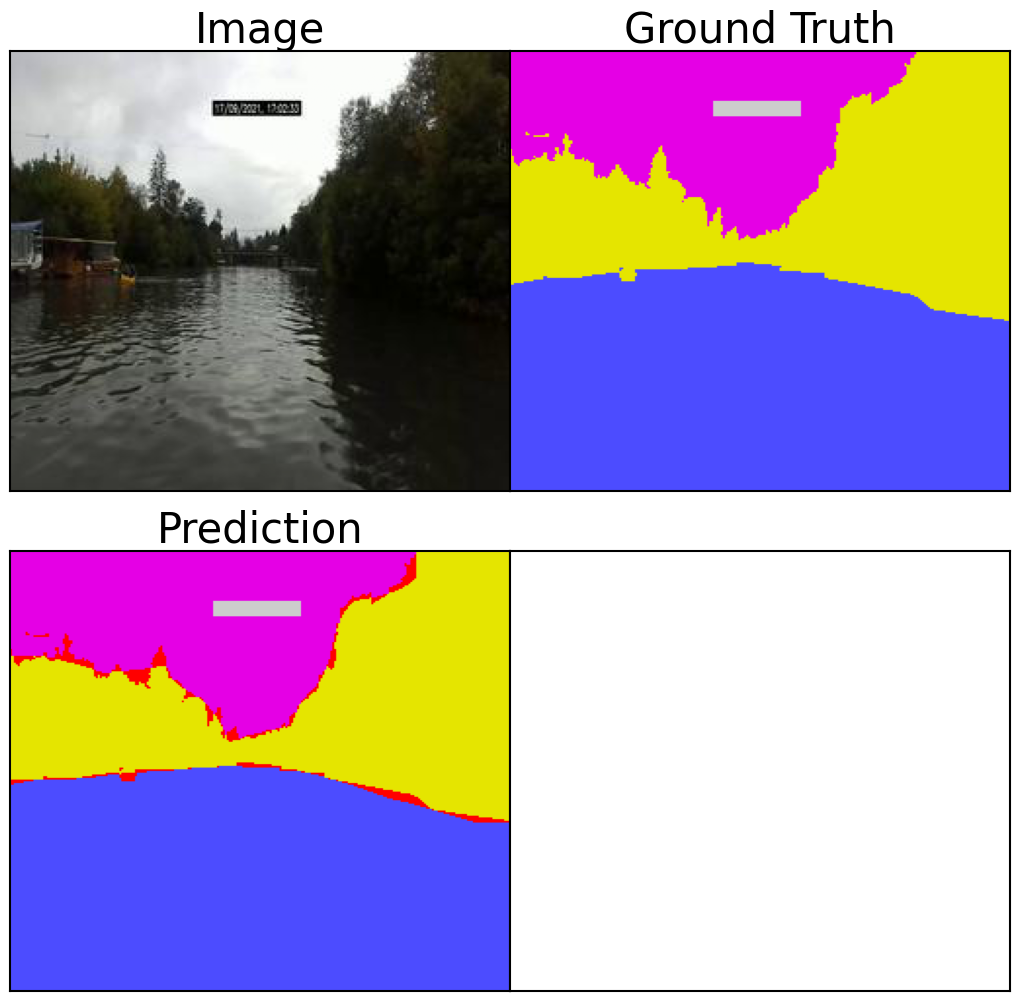

In [ ]:
#LaRS boat comparison
if __name__ == '__main__':
    path = './LaRS/'
    in_channels = 3
    num_classes = 3

    import sys
    sys.path.append(path)

    import config as lars_config
    import LaRS_dataset

    train_loader, test_loader, val_loader = LaRS_dataset.get_LaRS_datasets(lars_config.dataset_path, 
                                                                            resolution=256, 
                                                                            batch_size=16)

    

    # from MobileNetV2 import *
    # model = getDeepLabV3_MobileNetV2(num_classes, in_channels=in_channels)
    # model_file_dir = f'{path}MobileNetV2/MobileNetV2-epochs300.pth'
    # checkpoint = torch.load(model_file_dir, weights_only=False)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # icg = ImageComparisonGenMobileNetV2(model)
    # icg.save_output_quad(val_loader, samples=[0], num_classes=num_classes, do_save='lars-deeplab.eps')

    
    # from unets_classic import *
    # model = getUnetClassic('P', in_channels=in_channels, out_channels=num_classes)
    # model_file_dir = f'{path}u-net-CIARP/u-net-classic-aug-P-epochs300.pth'
    # checkpoint = torch.load(model_file_dir, weights_only=False)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # icg = ImageComparisonGenerator(model)
    # icg.save_output_row(val_loader, samples=[3,9], num_classes=num_classes, do_save='lars-unet.eps')


    # from ULite import ULite
    # model = ULite(in_channels=in_channels, out=num_classes)
    # model_file_dir = f'{path}U-Lite-VISAPP-2026/ULite-1-epochs300-best.pth'
    # checkpoint = torch.load(model_file_dir, weights_only=False)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # icg = ImageComparisonGenerator(model)
    # icg.save_output_row(val_loader, samples=[3,9], num_classes=num_classes, do_save='lars-ulite.eps')



